# San Francisco Crime Classification

Predict the category of crimes that occurred in the city by the bay

Competition on [Kaggle](https://www.kaggle.com/c/sf-crime)

## 0. Load Libraries

In [128]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps
import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
pd.set_option("display.max_columns", 30)

## 1. Load Data

In [187]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 2. File Structure and Content

In [3]:
print 'Train shape: {}'.format(train.shape)
print 'Test shape: {}'.format(test.shape)

Train shape: (878049, 9)
Test shape: (884262, 7)


In [4]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


## 3. Formatting

In [145]:
# Convert Dates feature to year, month, hour
train['Dates'] = pd.to_datetime(train.Dates)
train['Year'] = train.Dates.dt.year.astype(str)
train['Month'] = train.Dates.dt.month.astype(str)
train['Day'] = train.Dates.dt.day.astype(str)
train['Hour'] = train.Dates.dt.hour.astype(str)

## 4. Feature Exploration

In [8]:
crime_categories = train.Category.unique()
print 'Number of Crime Categories: {}\n'.format(len(crime_categories))
print 'Crime Categories: {}\n'.format(crime_categories)

districts = train.PdDistrict.unique()
print 'Number of Districts: {}\n'.format(len(districts))

Number of Crime Categories: 39

Crime Categories: ['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']

Number of Districts: 10



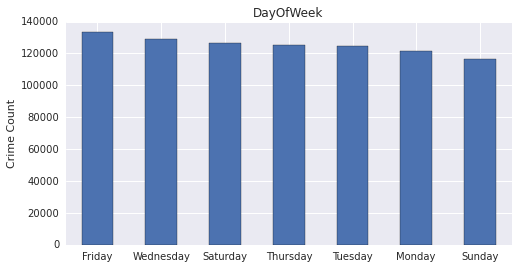

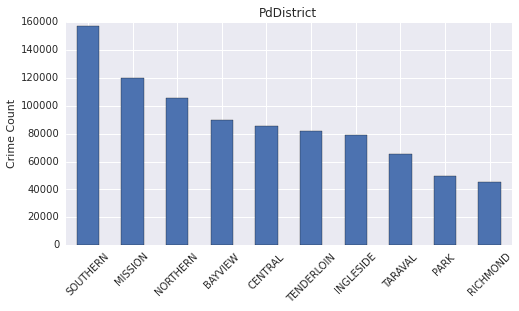

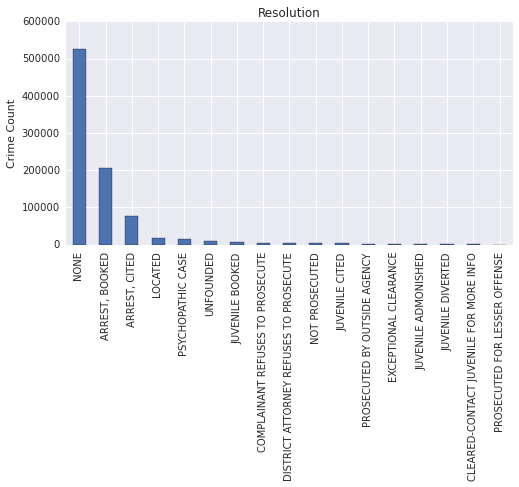

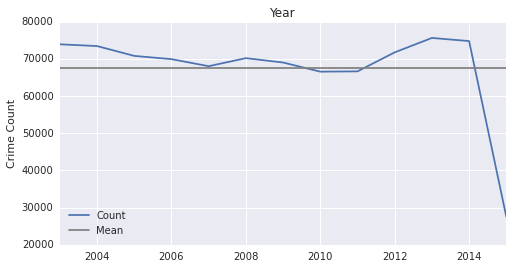

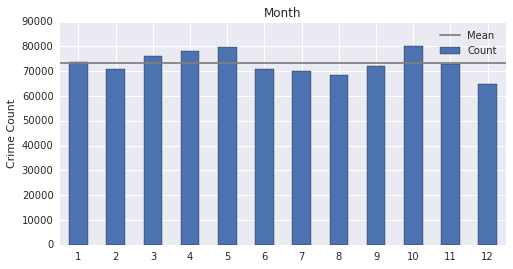

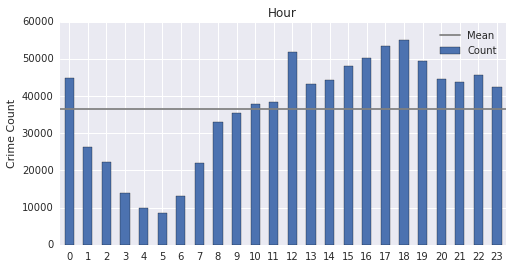

In [9]:
chartCols = ['DayOfWeek', 'PdDistrict', 'Resolution', 'Year', 'Month', 'Hour']
for c in chartCols:
    df = train[c].value_counts().reset_index()
    df.columns = [c, 'Count']
    df.set_index(c, inplace=True)
    
    # Convert string numbers to numeric
    numericCols = ['Year', 'Month', 'Hour']
    if c in numericCols:
        df.index = df.index.astype('int')
        df.sort_index(inplace=True)

    # Line chart for Year
    k = 'line' if c == 'Year' else 'bar'
    
    # Plot the value counts
    df.plot(kind=k, figsize=(8,4))
    plt.legend().set_visible(False)
    
    # Add a horizontal line at the mean for certain features
    if c in numericCols:
        mean = np.mean(df.Count)
        plt.axhline(mean, color='grey', label='Mean')
        plt.legend(loc=0)
    
    # Format rotation of x-axis labels
    if c in ['DayOfWeek', 'Year', 'Month', 'Hour']:
        r = 0
    elif c == 'Resolution':
        r = 90
    else:
        r = 45 

    plt.xticks(rotation=r)
    plt.xlabel('')
    plt.ylabel('Crime Count')
    plt.title(c)
    plt.show()

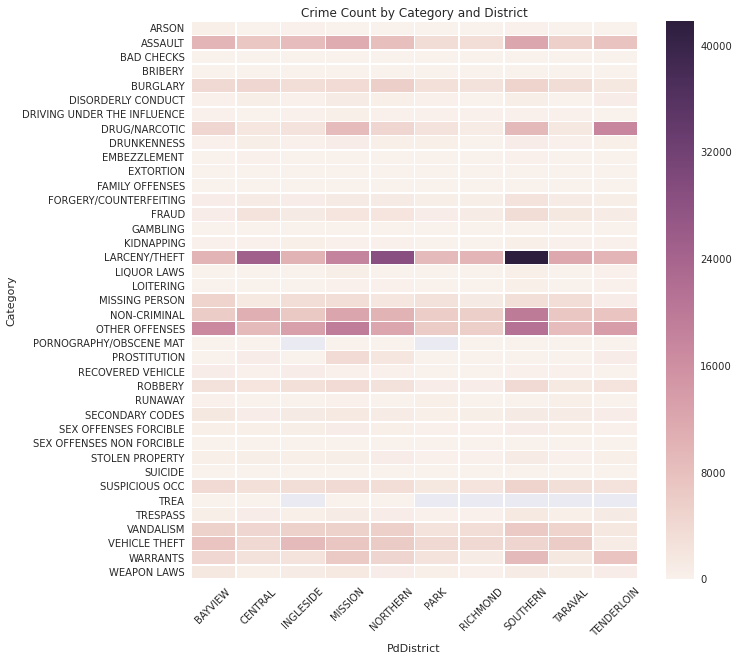

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(train.groupby(['Category', 'PdDistrict']).size().unstack(1), linewidths=0.2)
plt.title('Crime Count by Category and District')
plt.xticks(rotation=45)
plt.show()

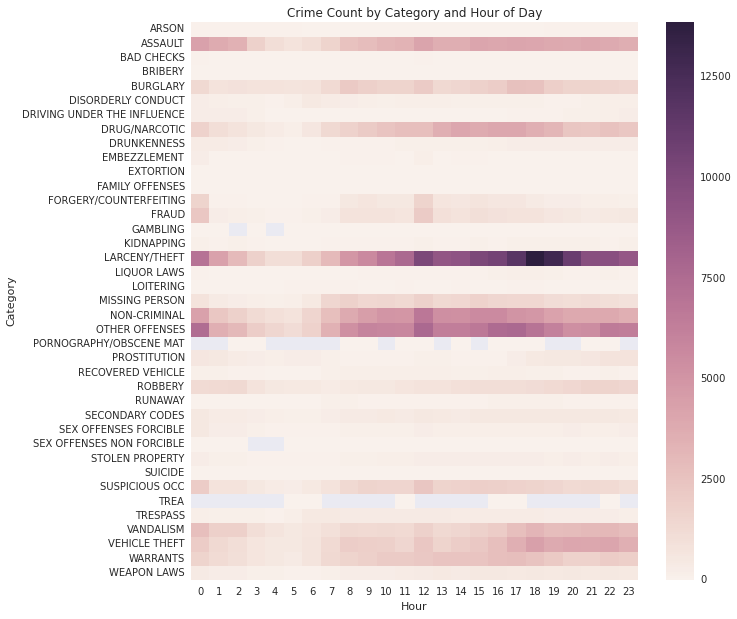

In [11]:
df = train.groupby(['Category', 'Hour']).size().unstack(1).reset_index()
cat = df.Category
del df['Category']
df.columns = df.columns.astype(int)
d = {'Hour': range(0,24), 'Column': np.array(df.columns)}
df_order = pd.DataFrame(d).sort_values('Column', ascending=True)
df_new = pd.DataFrame()
for i in df_order.Column.values:
    df_new = pd.concat([df_new, df[[i]]], axis=1)
df_new.set_index(cat, inplace=True)

plt.figure(figsize=(10,10))
sns.heatmap(df_new, linewidths=0.0)
plt.title('Crime Count by Category and Hour of Day')
plt.xticks(rotation=0)
plt.show()

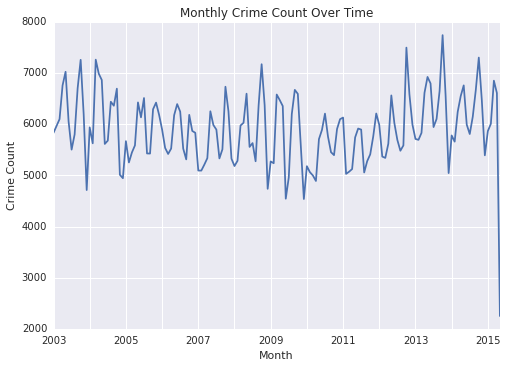

In [108]:
# Monthly crime count
train['Date'] = train.Dates.dt.date
train['Month'] = ['0'+m if len(m) == 1 else m for m in train.Month.values]
train['YearMonth'] = train['Year']+train['Month']
df_monthly = train.YearMonth.astype(int).value_counts().reset_index()
df_monthly.columns = ['Month', 'Count']
df_monthly['Count'] = df_monthly.Count.astype(int)
df_monthly['Month'] = pd.to_datetime(df_monthly.Month, format='%Y%m')
df_monthly.sort_values('Month', inplace=True)
df_monthly['Index'] = range(0,len(df_monthly))
df_monthly.set_index('Index', inplace=True)

df_monthly.plot(x='Month', y='Count')
plt.title('Monthly Crime Count Over Time')
plt.legend().set_visible(False)
plt.ylabel('Crime Count')
plt.show()

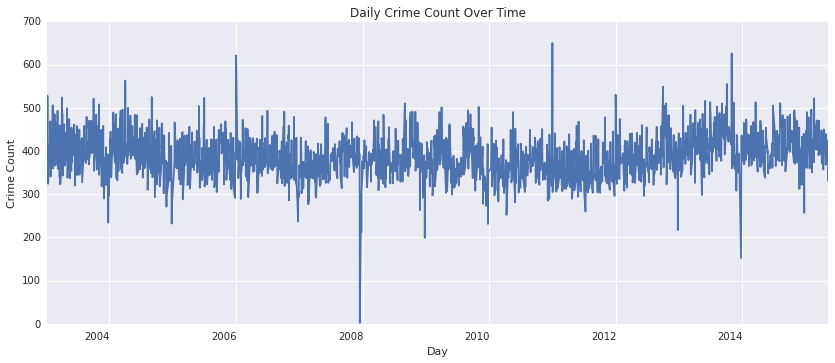

In [115]:
train['Date'] = train.Dates.dt.date
train['YearMonthDay'] = train['Year']+train['Month']+train['Day']
df_daily = train.YearMonthDay.astype(int).value_counts().reset_index()
df_daily.columns = ['Day', 'Count']
df_daily['Count'] = df_daily.Count.astype(int)
df_daily['Day'] = pd.to_datetime(df_daily.Day, format='%Y%m%d')
df_daily.sort_values('Day', inplace=True)
df_daily['Index'] = range(0,len(df_daily))
df_daily.set_index('Index', inplace=True)

df_daily.plot(x='Day', y='Count', figsize=(14,6))
plt.title('Daily Crime Count Over Time')
plt.legend().set_visible(False)
plt.ylabel('Crime Count')
plt.xticks(rotation=0)
plt.show()

In [112]:
# Basic summary statistics of daily crime count
avgCrimes = np.mean(df_daily.Count.values)
medCrimes = np.median(df_daily.Count.values)
minCrimes = np.min(df_daily.Count.values)
maxCrimes = np.max(df_daily.Count.values)
print 'Average number of crimes per day: {:.2f}'.format(avgCrimes)
print 'Median number of crimes per day: {}'.format(medCrimes)
print 'Min number of crimes per day: {}'.format(minCrimes)
print 'Max number of crimes per day: {}'.format(maxCrimes)

Average number of crimes per day: 390.42
Median number of crimes per day: 390.0
Min number of crimes per day: 2
Max number of crimes per day: 650


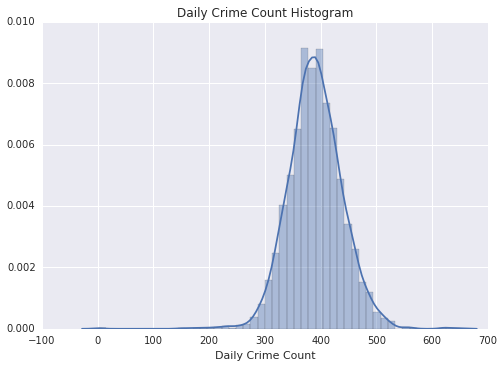

In [113]:
# Histogram of daily crime count
sns.distplot(df_daily.Count)
plt.title('Daily Crime Count Histogram')
plt.xlabel('Daily Crime Count')
plt.show()

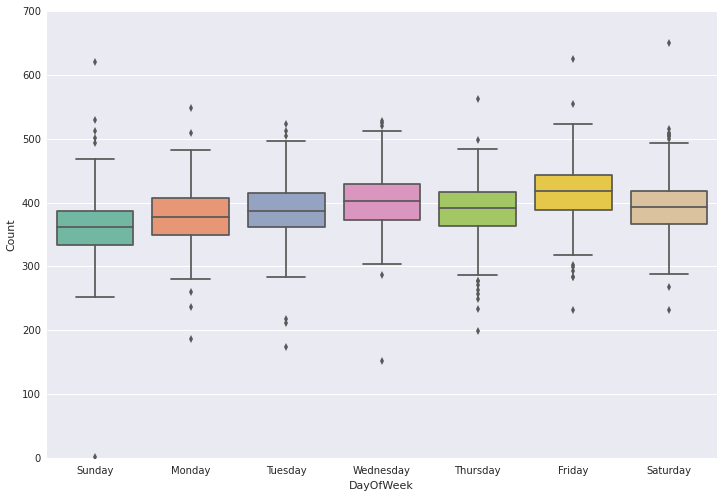

In [185]:
# Distribution of daily crime counts with respect to day of week
train['Date'] = train.Dates.dt.date
df_boxplot = pd.DataFrame(train.Date.value_counts()).reset_index()
df_boxplot.columns = ['Date', 'Count']
df_box= train[['DayOfWeek', 'Date']].merge(df_boxplot, how='inner', on='Date').drop_duplicates(keep='first')

plt.figure(figsize=(12,8))
order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.boxplot(x='DayOfWeek', y='Count', data=df_box, palette='Set2', order=order)
plt.show()

## 5. Predictive Modeling

In [ ]:
print 'Formatting data...\n'
# Store label
label = train['Category']
del train['Category']

# Store test_id 
test_id = test['Id']
del test['Id']

# Remove lat, lon, and address for now - will include these in future models
del train['X']
del train['Y']
del test['X']
del test['Y']
del train['Address']
del test['Address']
total = pd.concat([train, test], ignore_index=True)

# Remove column that is not in test data
del train['Descript']

# Convert Dates feature to year, month, hour
total['Dates'] = pd.to_datetime(total.Dates)
total['Year'] = total.Dates.dt.year.astype(str)
total['Month'] = total.Dates.dt.month.astype(str)
total['Hour'] = total.Dates.dt.hour.astype(str)
del total['Dates']

# One-hot encoding
print 'One-hot encoding...\n'
dummies = pd.get_dummies(total)
train_dummies = dummies.head(len(train))
test_dummies = dummies.tail(len(test))

# Logistic Regression - Tune Parameters with GridSearchCV, 3-folds
start = time.time()

print 'Tuning parameters and fitting best model...\n'
parameters = {'C': np.arange(0.1, 1.1, 0.1), 'fit_intercept': [True, False]}
log_reg = LogisticRegression(penalty='l1', solver='liblinear')
clf = GridSearchCV(log_reg, parameters, scoring='accuracy', refit=True)
clf.fit(train_dummies, label)

print 'Logistic Regression Tuned with GridSearchCV'
print 'Best parameters: {}'.format(clf.best_params_)
print 'Best GridSearchCV log_loss score: {}\n'.format(clf.best_score_)

# Prediction
print 'Making predictions...\n'
preds = clf.predict_proba(test_dummies)

end = time.time()
run_time = float(end - start)/60

# Format submission
print 'Formatting submission...\n'
sub_number = 2
df_preds = pd.DataFrame(preds)
df_preds.columns = clf.classes_
id_list = range(0, len(preds))
df_id = pd.DataFrame({'Id': id_list})
df = pd.concat([df_id, df_preds], axis=1)
df.to_csv('submissions/submission{}.csv'.format(sub_number), index=False)

print 'Modeling complete!'
print 'Run time of model selection, fitting, and predictions: {:0.2f} minutes\n'.format(run_time)

Formatting data...

One-hot encoding...

Tuning parameters and fitting best model...

